In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ape import accounts, chain, Contract, networks, project

In [3]:
# SEE: https://gist.github.com/banteg/dcf6082ff7fc6ad51ce220146f29d9ff
networks.parse_network_choice('ethereum:mainnet:alchemy').__enter__()

<alchemy chain_id=1>

In [4]:
# USDC/WETH 5bps pool, 8h candles over Dec 2022 to May 2023
# @dev {tick_width: fp}
FILEPATHS = {
   2800: "results/backtest/UniswapV3LPSimpleRunner_0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640_2800_7200_16219692_17267692_2400.csv",
   5600: "results/backtest/UniswapV3LPSimpleRunner_0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640_5600_7200_16219692_17267692_2400.csv",
   8400: "results/backtest/UniswapV3LPSimpleRunner_0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640_8400_7200_16219692_17267692_2400.csv",
   11200: "results/backtest/UniswapV3LPSimpleRunner_0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640_11200_7200_16219692_17267692_2400.csv",
   14000: "results/backtest/UniswapV3LPSimpleRunner_0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640_14000_7200_16219692_17267692_2400.csv",
   16800: "results/backtest/UniswapV3LPSimpleRunner_0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640_16800_7200_16219692_17267692_2400.csv",
   22400: "results/backtest/UniswapV3LPSimpleRunner_0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640_22400_7200_16219692_17267692_2400.csv",
   33600: "results/backtest/UniswapV3LPSimpleRunner_0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640_33600_7200_16219692_17267692_2400.csv",
   44800: "results/backtest/UniswapV3LPSimpleRunner_0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640_44800_7200_16219692_17267692_2400.csv",
    0: "results/backtest/UniswapV3LPSimpleRunner_0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640_0_7200_16219692_17267692_2400.csv",  # full range LP
}

In [5]:
df = pd.read_csv(FILEPATHS[0])
df

,number,values0,values1,values2,values3,sqrtPriceX96,tick,liquidity,feeGrowthGlobal0X128,feeGrowthGlobal1X128,position_token_id,position_liquidity,position_tick_lower,position_tick_upper,position_amount0,position_amount1,position_fees0_cumulative,position_fees1_cumulative
0,16219693,1184180473737,1000096373981086032955,0,48211096091070,2302457180693885351454651093163492,205553,31203981017892687890,2181620581902003936411883992456929,1026699780925062056301321001565722942741084,-1,34413581591046522,-887270,887270,1184294597923,1000000000000000000000,0,0
1,16222093,1175860832468,1007172418046749714633,36870369,35121222243234717,2318747899162385489001287554456344,205694,17540821031132433136,2181985157052788187585985499073660,1027046583748145707407639599439896464086763,-1,34413581591046522,-887270,887270,1184294597923,1000000000000000000000,0,0
2,16224493,1195620849490,990526886870751338638,79507064,62541008198979213,2280425969616657314568929983238151,205361,30523448134936311091,2182406749771601875934982373447527,1027317711286579945199071017760952647928490,-1,34413581591046522,-887270,887270,1184294597923,1000000000000000000000,0,0
3,16226893,1203225714564,984266362984504881565,110750550,85149890953964578,2266012770497242894086255374140612,205234,20905059435363221456,2182715686150892854181613442855243,1027541268492241619844457934521929909830784,-1,34413581591046522,-887270,887270,1184294597923,1000000000000000000000,0,0
4,16229293,1200989209550,986275362611888780077,23041406,19906669647239693,2270435262486917424056195007509857,205273,22227312718227892744,2182943499819872818882169549269372,1027738088574684734465475778290005927962009,-1,34416653935879386,-887270,887270,1203333135233,984354235432958918525,110750550,85149890953964578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,17256493,1483531666195,820791900865718094151,49305725,26475793703772034,1863578556449392031538434625661268,201323,27420357340978417904,2374915665675843076475381608708728,1143303341153993455122962271726629264301423,-1,34895139723049839,-887270,887270,1480234759987,822620040623526736953,19637031525,11845236998428987242
433,17258893,1488138579228,818304518861634471574,14056381,6520485285497433,1857870207979672951132848076883101,201262,28684533318695592725,2375052732962575387887576720301920,1143366924034890098429964558540172533901472,-1,34896282381872287,-887270,887270,1483580245964,820818778107487647719,19686337250,11871712792132759276
434,17261293,1479470248169,823099028576077162663,27350472,16283872429414352,1868755613785232690185652557661677,201379,20097267437575475732,2375182366967365283755698550567022,1143462129261915180149816108783753626834180,-1,34896282381872287,-887270,887270,1483580245964,820818778107487647719,19686337250,11871712792132759276
435,17263693,1493455353249,815391314796296811690,56383853,28434060989323540,1851256099273191187753267917130117,201190,29915981331513473191,2375465478720511304356360392619927,1143580608785792754282024902648959495253213,-1,34896282381872287,-887270,887270,1483580245964,820818778107487647719,19686337250,11871712792132759276


In [6]:
def price(sqrt_price_x96: int) -> int:
    return (int(sqrt_price_x96) ** 2) // (1 << 192)

In [7]:
df['price'] = df['sqrtPriceX96'].apply(price)
df['price']

0      844547259
1      856540493
2      828462373
3      818023045
4      821219170
         ...    
432    553268878
433    549884621
434    556347131
435    545976358
436    547272835
Name: price, Length: 437, dtype: int64

<Axes: xlabel='number'>

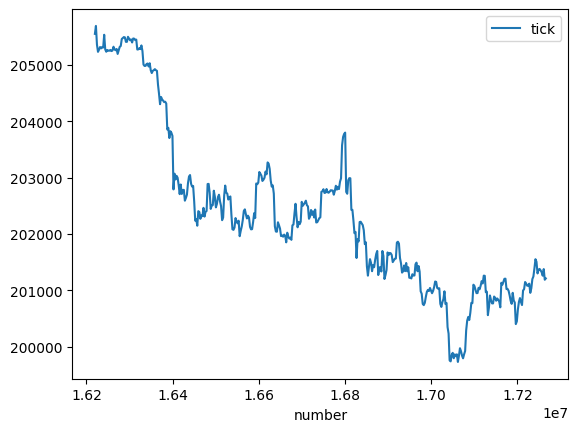

In [8]:
df.plot(x='number', y='tick')

In [9]:
# theta = fee volume per second per unit of external virtual liquidity
# TODO: fix to remove LPs liquidity from df['liquidity']
df['theta0'] = (df['price'] * df['feeGrowthGlobal0X128'].astype('float').diff() / df['number'].astype('float').diff()) / ((1 << 32) * df['sqrtPriceX96'].astype('float'))
df['theta1'] = (df['feeGrowthGlobal1X128'].astype('float').diff() / df['number'].astype('float').diff()) / ((1 << 32) * df['sqrtPriceX96'].astype('float'))
df['theta'] = (df['theta0'] + df['theta1']) / 2  # avg

In [10]:
df

,number,values0,values1,values2,values3,sqrtPriceX96,tick,liquidity,feeGrowthGlobal0X128,feeGrowthGlobal1X128,...,position_tick_lower,position_tick_upper,position_amount0,position_amount1,position_fees0_cumulative,position_fees1_cumulative,price,theta0,theta1,theta
0,16219693,1184180473737,1000096373981086032955,0,48211096091070,2302457180693885351454651093163492,205553,31203981017892687890,2181620581902003936411883992456929,1026699780925062056301321001565722942741084,...,-887270,887270,1184294597923,1000000000000000000000,0,0,844547259,NaN,NaN,NaN
1,16222093,1175860832468,1007172418046749714633,36870369,35121222243234717,2318747899162385489001287554456344,205694,17540821031132433136,2181985157052788187585985499073660,1027046583748145707407639599439896464086763,...,-887270,887270,1184294597923,1000000000000000000000,0,0,856540493,1.306503e-08,1.450969e-08,1.378736e-08
2,16224493,1195620849490,990526886870751338638,79507064,62541008198979213,2280425969616657314568929983238151,205361,30523448134936311091,2182406749771601875934982373447527,1027317711286579945199071017760952647928490,...,-887270,887270,1184294597923,1000000000000000000000,0,0,828462373,1.485863e-08,1.153418e-08,1.319640e-08
3,16226893,1203225714564,984266362984504881565,110750550,85149890953964578,2266012770497242894086255374140612,205234,20905059435363221456,2182715686150892854181613442855243,1027541268492241619844457934521929909830784,...,-887270,887270,1184294597923,1000000000000000000000,0,0,818023045,1.081935e-08,9.570954e-09,1.019515e-08
4,16229293,1200989209550,986275362611888780077,23041406,19906669647239693,2270435262486917424056195007509857,205273,22227312718227892744,2182943499819872818882169549269372,1027738088574684734465475778290005927962009,...,-887270,887270,1203333135233,984354235432958918525,110750550,85149890953964578,821219170,7.993899e-09,8.409868e-09,8.201883e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,17256493,1483531666195,820791900865718094151,49305725,26475793703772034,1863578556449392031538434625661268,201323,27420357340978417904,2374915665675843076475381608708728,1143303341153993455122962271726629264301423,...,-887270,887270,1480234759987,822620040623526736953,19637031525,11845236998428987242,553268878,3.270639e-09,2.942281e-09,3.106460e-09
433,17258893,1488138579228,818304518861634471574,14056381,6520485285497433,1857870207979672951132848076883101,201262,28684533318695592725,2375052732962575387887576720301920,1143366924034890098429964558540172533901472,...,-887270,887270,1483580245964,820818778107487647719,19686337250,11871712792132759276,549884621,3.935672e-09,3.320120e-09,3.627896e-09
434,17261293,1479470248169,823099028576077162663,27350472,16283872429414352,1868755613785232690185652557661677,201379,20097267437575475732,2375182366967365283755698550567022,1143462129261915180149816108783753626834180,...,-887270,887270,1483580245964,820818778107487647719,19686337250,11871712792132759276,556347131,3.744046e-09,4.942392e-09,4.343219e-09
435,17263693,1493455353249,815391314796296811690,56383853,28434060989323540,1851256099273191187753267917130117,201190,29915981331513473191,2375465478720511304356360392619927,1143580608785792754282024902648959495253213,...,-887270,887270,1483580245964,820818778107487647719,19686337250,11871712792132759276,545976358,8.100170e-09,6.208772e-09,7.154471e-09


<Axes: xlabel='number'>

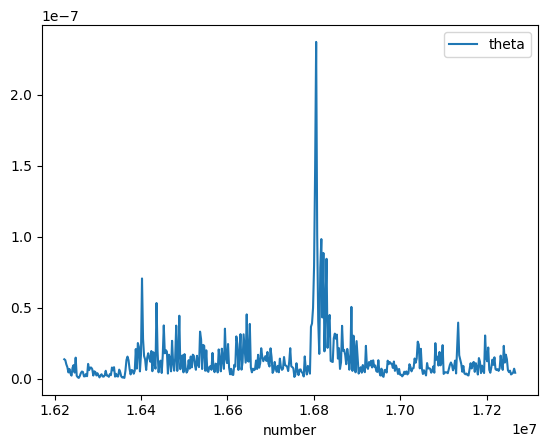

In [11]:
df.plot(x='number', y='theta')

In [12]:
# since compounding fees into principal each rebalance, only look at principal timeseries in units of token1
df['v-inf'] = (df['values0'].astype('float')) * df['price'] + df['values1'].astype('float')
df['y-inf'] = df['v-inf'] / df['v-inf'].iloc[0] - 1  # yield vs initial principal
df['i-inf'] = df['v-inf'] / (df['position_amount0'].astype('float').iloc[0] * df['price'] + df['position_amount1'].astype('float').iloc[0]) - 1  # yield vs initial passive hold

In [13]:
# accumulated fees and rate of return on them vs original principal value
df['f-inf'] = (df['position_fees0_cumulative'].astype('float')) * df['price'] + df['position_fees1_cumulative'].astype('float')
df['r-inf'] = df['f-inf'] / df['v-inf'].iloc[0]

In [14]:
df

,number,values0,values1,values2,values3,sqrtPriceX96,tick,liquidity,feeGrowthGlobal0X128,feeGrowthGlobal1X128,...,position_fees1_cumulative,price,theta0,theta1,theta,v-inf,y-inf,i-inf,f-inf,r-inf
0,16219693,1184180473737,1000096373981086032955,0,48211096091070,2302457180693885351454651093163492,205553,31203981017892687890,2181620581902003936411883992456929,1026699780925062056301321001565722942741084,...,0,844547259,NaN,NaN,NaN,2.000193e+21,0.000000,-4.643245e-09,0.000000e+00,0.000000
1,16222093,1175860832468,1007172418046749714633,36870369,35121222243234717,2318747899162385489001287554456344,205694,17540821031132433136,2181985157052788187585985499073660,1027046583748145707407639599439896464086763,...,0,856540493,1.306503e-08,1.450969e-08,1.378736e-08,2.014345e+21,0.007075,-2.553796e-05,0.000000e+00,0.000000
2,16224493,1195620849490,990526886870751338638,79507064,62541008198979213,2280425969616657314568929983238151,205361,30523448134936311091,2182406749771601875934982373447527,1027317711286579945199071017760952647928490,...,0,828462373,1.485863e-08,1.153418e-08,1.319640e-08,1.981054e+21,-0.009569,-4.529701e-05,0.000000e+00,0.000000
3,16226893,1203225714564,984266362984504881565,110750550,85149890953964578,2266012770497242894086255374140612,205234,20905059435363221456,2182715686150892854181613442855243,1027541268492241619844457934521929909830784,...,0,818023045,1.081935e-08,9.570954e-09,1.019515e-08,1.968533e+21,-0.015828,-1.257364e-04,0.000000e+00,0.000000
4,16229293,1200989209550,986275362611888780077,23041406,19906669647239693,2270435262486917424056195007509857,205273,22227312718227892744,2182943499819872818882169549269372,1027738088574684734465475778290005927962009,...,85149890953964578,821219170,7.993899e-09,8.409868e-09,8.201883e-09,1.972551e+21,-0.013820,-7.453382e-06,1.761004e+17,0.000088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,17256493,1483531666195,820791900865718094151,49305725,26475793703772034,1863578556449392031538434625661268,201323,27420357340978417904,2374915665675843076475381608708728,1143303341153993455122962271726629264301423,...,11845236998428987242,553268878,3.270639e-09,2.942281e-09,3.106460e-09,1.641584e+21,-0.179287,-8.246295e-03,2.270980e+19,0.011354
433,17258893,1488138579228,818304518861634471574,14056381,6520485285497433,1857870207979672951132848076883101,201262,28684533318695592725,2375052732962575387887576720301920,1143366924034890098429964558540172533901472,...,11871712792132759276,549884621,3.935672e-09,3.320120e-09,3.627896e-09,1.636609e+21,-0.181774,-8.851819e-03,2.269693e+19,0.011347
434,17261293,1479470248169,823099028576077162663,27350472,16283872429414352,1868755613785232690185652557661677,201379,20097267437575475732,2375182366967365283755698550567022,1143462129261915180149816108783753626834180,...,11871712792132759276,556347131,3.744046e-09,4.942392e-09,4.343219e-09,1.646198e+21,-0.176980,-7.644226e-03,2.282415e+19,0.011411
435,17263693,1493455353249,815391314796296811690,56383853,28434060989323540,1851256099273191187753267917130117,201190,29915981331513473191,2375465478720511304356360392619927,1143580608785792754282024902648959495253213,...,11871712792132759276,545976358,8.100170e-09,6.208772e-09,7.154471e-09,1.630783e+21,-0.184687,-9.604186e-03,2.261999e+19,0.011309


<Axes: xlabel='number'>

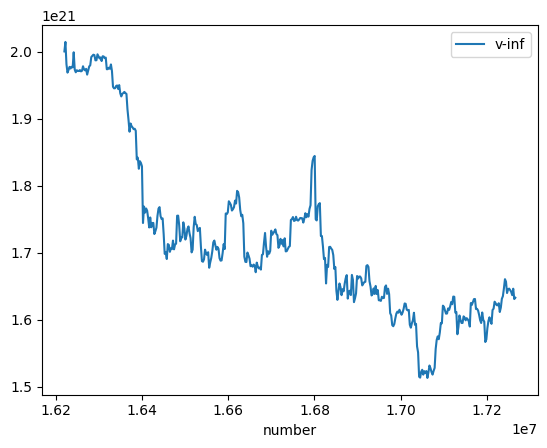

In [15]:
# value in units of token1 over time
df.plot(x='number', y='v-inf')

<Axes: xlabel='number'>

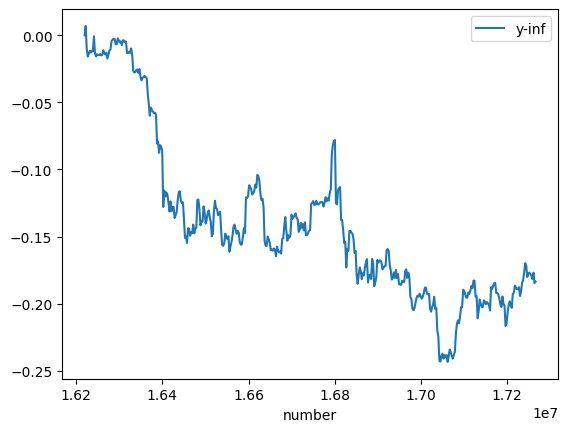

In [16]:
# yield in units of token1 over time relative to initial principal
df.plot(x='number', y='y-inf')

<Axes: xlabel='number'>

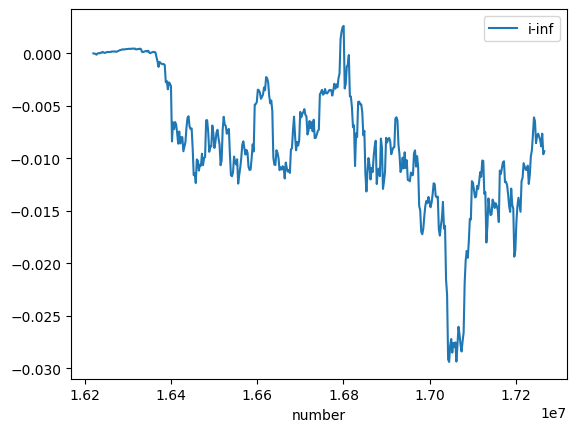

In [17]:
# yield in units of token1 over time relative to passive hold
df.plot(x='number', y='i-inf')

<Axes: xlabel='number'>

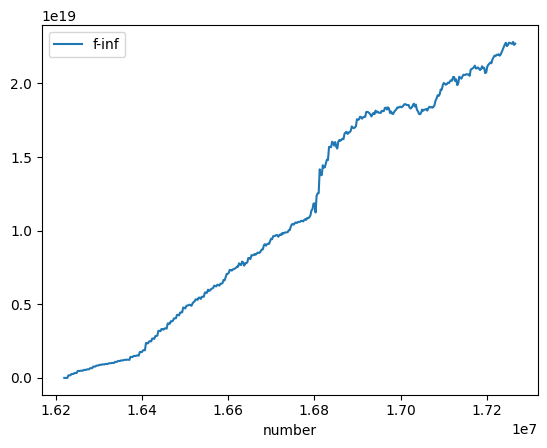

In [18]:
# accumulated fees in units of token1 over time
df.plot(x='number', y='f-inf')

<Axes: xlabel='number'>

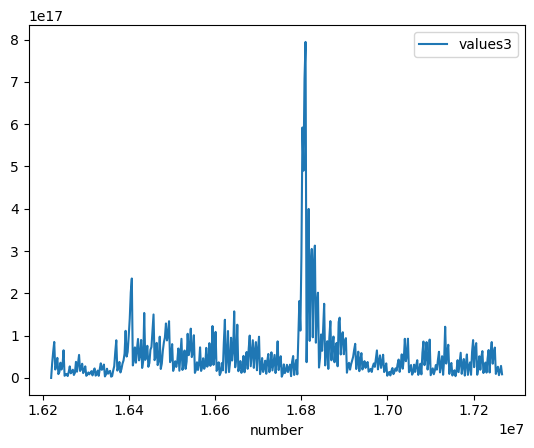

In [19]:
# fees in units of token1 over time
df.plot(x='number', y='values3')

<Axes: xlabel='number'>

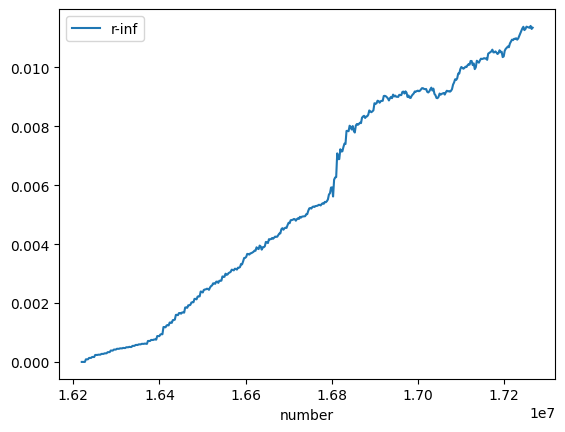

In [20]:
# fee return in units of token1 over time
df.plot(x='number', y='r-inf')

In [21]:
df.columns

Index(['number', 'values0', 'values1', 'values2', 'values3', 'sqrtPriceX96',
       'tick', 'liquidity', 'feeGrowthGlobal0X128', 'feeGrowthGlobal1X128',
       'position_token_id', 'position_liquidity', 'position_tick_lower',
       'position_tick_upper', 'position_amount0', 'position_amount1',
       'position_fees0_cumulative', 'position_fees1_cumulative', 'price',
       'theta0', 'theta1', 'theta', 'v-inf', 'y-inf', 'i-inf', 'f-inf',
       'r-inf'],
      dtype='object')

In [22]:
# drop columns that are tick width dependent to build df across each backtest file
df.drop(columns=[f'values{i}' for i in range(4)], inplace=True)

In [23]:
df.drop(columns=[
    'position_token_id',
    'position_liquidity',
    'position_tick_lower',
    'position_tick_upper',
    'position_amount0',
    'position_amount1',
    'position_fees0_cumulative',
    'position_fees1_cumulative'
], inplace=True)

In [24]:
df

,number,sqrtPriceX96,tick,liquidity,feeGrowthGlobal0X128,feeGrowthGlobal1X128,price,theta0,theta1,theta,v-inf,y-inf,i-inf,f-inf,r-inf
0,16219693,2302457180693885351454651093163492,205553,31203981017892687890,2181620581902003936411883992456929,1026699780925062056301321001565722942741084,844547259,NaN,NaN,NaN,2.000193e+21,0.000000,-4.643245e-09,0.000000e+00,0.000000
1,16222093,2318747899162385489001287554456344,205694,17540821031132433136,2181985157052788187585985499073660,1027046583748145707407639599439896464086763,856540493,1.306503e-08,1.450969e-08,1.378736e-08,2.014345e+21,0.007075,-2.553796e-05,0.000000e+00,0.000000
2,16224493,2280425969616657314568929983238151,205361,30523448134936311091,2182406749771601875934982373447527,1027317711286579945199071017760952647928490,828462373,1.485863e-08,1.153418e-08,1.319640e-08,1.981054e+21,-0.009569,-4.529701e-05,0.000000e+00,0.000000
3,16226893,2266012770497242894086255374140612,205234,20905059435363221456,2182715686150892854181613442855243,1027541268492241619844457934521929909830784,818023045,1.081935e-08,9.570954e-09,1.019515e-08,1.968533e+21,-0.015828,-1.257364e-04,0.000000e+00,0.000000
4,16229293,2270435262486917424056195007509857,205273,22227312718227892744,2182943499819872818882169549269372,1027738088574684734465475778290005927962009,821219170,7.993899e-09,8.409868e-09,8.201883e-09,1.972551e+21,-0.013820,-7.453382e-06,1.761004e+17,0.000088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,17256493,1863578556449392031538434625661268,201323,27420357340978417904,2374915665675843076475381608708728,1143303341153993455122962271726629264301423,553268878,3.270639e-09,2.942281e-09,3.106460e-09,1.641584e+21,-0.179287,-8.246295e-03,2.270980e+19,0.011354
433,17258893,1857870207979672951132848076883101,201262,28684533318695592725,2375052732962575387887576720301920,1143366924034890098429964558540172533901472,549884621,3.935672e-09,3.320120e-09,3.627896e-09,1.636609e+21,-0.181774,-8.851819e-03,2.269693e+19,0.011347
434,17261293,1868755613785232690185652557661677,201379,20097267437575475732,2375182366967365283755698550567022,1143462129261915180149816108783753626834180,556347131,3.744046e-09,4.942392e-09,4.343219e-09,1.646198e+21,-0.176980,-7.644226e-03,2.282415e+19,0.011411
435,17263693,1851256099273191187753267917130117,201190,29915981331513473191,2375465478720511304356360392619927,1143580608785792754282024902648959495253213,545976358,8.100170e-09,6.208772e-09,7.154471e-09,1.630783e+21,-0.184687,-9.604186e-03,2.261999e+19,0.011309


In [25]:
# calculate principal, fees, yield and fee return timeseries for each index in files array
for tick_width, fp in FILEPATHS.items():
    if tick_width == 0:
        continue

    _df = pd.read_csv(fp)

    # value (v), yield vs initial principal (y), yield vs passive hold (i) 
    df[f'v-{tick_width}'] = (_df['values0'].astype('float')) * df['price'] + _df['values1'].astype('float')
    df[f'y-{tick_width}'] = df[f'v-{tick_width}'] / df[f'v-{tick_width}'].iloc[0] - 1  # yield vs initial principal
    df[f'i-{tick_width}'] = df[f'v-{tick_width}'] / (_df['position_amount0'].astype('float').iloc[0] * df['price'] + _df['position_amount1'].astype('float').iloc[0]) - 1  # yield vs initial passive hold

    # cumulative fees (f), return from fees vs initial principal (r)
    df[f'f-{tick_width}'] = (_df['position_fees0_cumulative'].astype('float')) * df['price'] + _df['position_fees1_cumulative'].astype('float')
    df[f'r-{tick_width}'] = df[f'f-{tick_width}'] / df[f'v-{tick_width}'].iloc[0]

In [26]:
df

,number,sqrtPriceX96,tick,liquidity,feeGrowthGlobal0X128,feeGrowthGlobal1X128,price,theta0,theta1,theta,...,v-33600,y-33600,i-33600,f-33600,r-33600,v-44800,y-44800,i-44800,f-44800,r-44800
0,16219693,2302457180693885351454651093163492,205553,31203981017892687890,2181620581902003936411883992456929,1026699780925062056301321001565722942741084,844547259,NaN,NaN,NaN,...,2.000082e+21,0.000000,-8.171386e-09,0.000000e+00,0.000000,2.000122e+21,0.000000,-6.892422e-09,0.000000e+00,0.000000
1,16222093,2318747899162385489001287554456344,205694,17540821031132433136,2181985157052788187585985499073660,1027046583748145707407639599439896464086763,856540493,1.306503e-08,1.450969e-08,1.378736e-08,...,2.014193e+21,0.007055,-4.493975e-05,0.000000e+00,0.000000,2.014248e+21,0.007063,-3.790692e-05,0.000000e+00,0.000000
2,16224493,2280425969616657314568929983238151,205361,30523448134936311091,2182406749771601875934982373447527,1027317711286579945199071017760952647928490,828462373,1.485863e-08,1.153418e-08,1.319640e-08,...,1.980877e+21,-0.009602,-7.971014e-05,0.000000e+00,0.000000,1.980941e+21,-0.009590,-6.723596e-05,0.000000e+00,0.000000
3,16226893,2266012770497242894086255374140612,205234,20905059435363221456,2182715686150892854181613442855243,1027541268492241619844457934521929909830784,818023045,1.081935e-08,9.570954e-09,1.019515e-08,...,1.968237e+21,-0.015922,-2.212610e-04,0.000000e+00,0.000000,1.968344e+21,-0.015888,-1.866349e-04,0.000000e+00,0.000000
4,16229293,2270435262486917424056195007509857,205273,22227312718227892744,2182943499819872818882169549269372,1027738088574684734465475778290005927962009,821219170,7.993899e-09,8.409868e-09,8.201883e-09,...,1.972059e+21,-0.014011,-2.021545e-04,3.098706e+17,0.000155,1.972237e+21,-0.013942,-1.315585e-04,2.613828e+17,0.000131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,17256493,1863578556449392031538434625661268,201323,27420357340978417904,2374915665675843076475381608708728,1143303341153993455122962271726629264301423,553268878,3.270639e-09,2.942281e-09,3.106460e-09,...,1.620673e+21,-0.189697,-2.083648e-02,3.968426e+19,0.019841,1.628226e+21,-0.185937,-1.628886e-02,3.355892e+19,0.016778
433,17258893,1857870207979672951132848076883101,201262,28684533318695592725,2375052732962575387887576720301920,1143366924034890098429964558540172533901472,549884621,3.935672e-09,3.320120e-09,3.627896e-09,...,1.615574e+21,-0.192246,-2.154790e-02,3.966124e+19,0.019830,1.623172e+21,-0.188464,-1.696223e-02,3.353962e+19,0.016769
434,17261293,1868755613785232690185652557661677,201379,20097267437575475732,2375182366967365283755698550567022,1143462129261915180149816108783753626834180,556347131,3.744046e-09,4.942392e-09,4.343219e-09,...,1.625040e+21,-0.187513,-2.035562e-02,3.988353e+19,0.019941,1.632682e+21,-0.183709,-1.576442e-02,3.372761e+19,0.016863
435,17263693,1851256099273191187753267917130117,201190,29915981331513473191,2375465478720511304356360392619927,1143580608785792754282024902648959495253213,545976358,8.100170e-09,6.208772e-09,7.154471e-09,...,1.609802e+21,-0.195132,-2.230319e-02,3.952681e+19,0.019763,1.617380e+21,-0.191359,-1.771648e-02,3.342594e+19,0.016712


In [27]:
df.columns

Index(['number', 'sqrtPriceX96', 'tick', 'liquidity', 'feeGrowthGlobal0X128',
       'feeGrowthGlobal1X128', 'price', 'theta0', 'theta1', 'theta', 'v-inf',
       'y-inf', 'i-inf', 'f-inf', 'r-inf', 'v-2800', 'y-2800', 'i-2800',
       'f-2800', 'r-2800', 'v-5600', 'y-5600', 'i-5600', 'f-5600', 'r-5600',
       'v-8400', 'y-8400', 'i-8400', 'f-8400', 'r-8400', 'v-11200', 'y-11200',
       'i-11200', 'f-11200', 'r-11200', 'v-14000', 'y-14000', 'i-14000',
       'f-14000', 'r-14000', 'v-16800', 'y-16800', 'i-16800', 'f-16800',
       'r-16800', 'v-22400', 'y-22400', 'i-22400', 'f-22400', 'r-22400',
       'v-33600', 'y-33600', 'i-33600', 'f-33600', 'r-33600', 'v-44800',
       'y-44800', 'i-44800', 'f-44800', 'r-44800'],
      dtype='object')

In [28]:
tick_widths = list(FILEPATHS.keys())
tick_widths

[2800, 5600, 8400, 11200, 14000, 16800, 22400, 33600, 44800, 0]

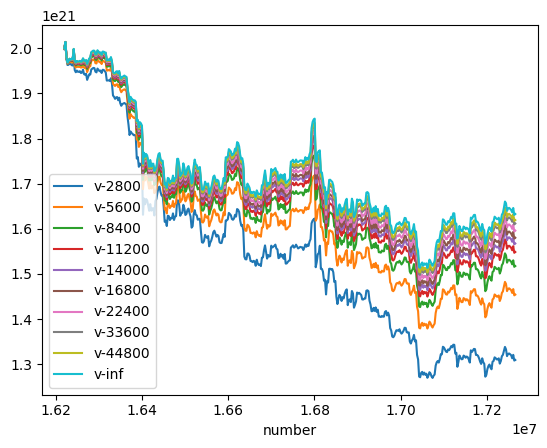

In [29]:
# values in units of token1 over time
ax = df.plot(x='number', y=[f'v-{tick_width}' if tick_width > 0 else 'v-inf' for tick_width in tick_widths])
ax.get_figure().savefig('results/backtest/UniswapV3LPSimpleRunner_0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640_values_7200_16219692_17267692_2400.png')

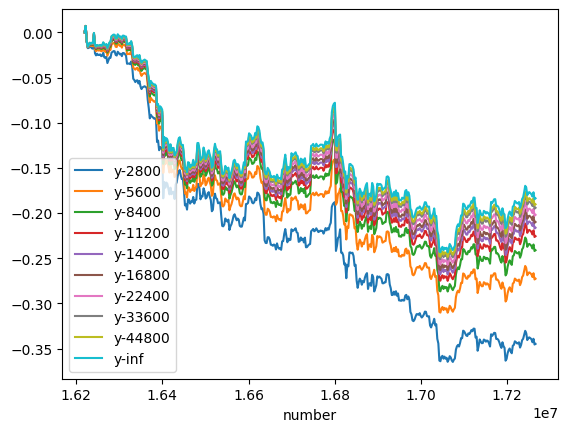

In [30]:
# yields in units of token1 over time
ax = df.plot(x='number', y=[f'y-{tick_width}' if tick_width > 0 else 'y-inf' for tick_width in tick_widths])
ax.get_figure().savefig('results/backtest/UniswapV3LPSimpleRunner_0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640_yields_7200_16219692_17267692_2400.png')

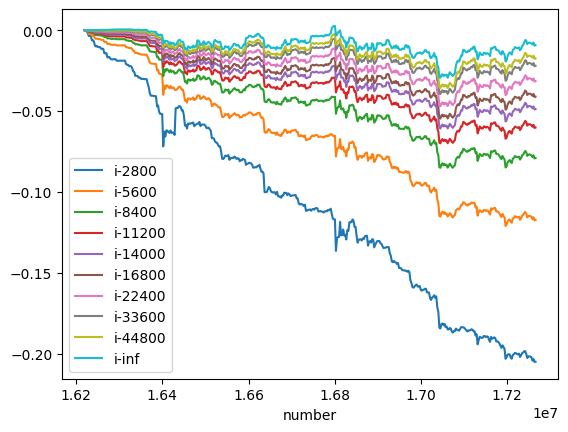

In [31]:
# yields in units of token1 over time relative to passive hold
ax = df.plot(x='number', y=[f'i-{tick_width}' if tick_width > 0 else 'i-inf' for tick_width in tick_widths])
ax.get_figure().savefig('results/backtest/UniswapV3LPSimpleRunner_0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640_yields_v_hold_7200_16219692_17267692_2400.png')

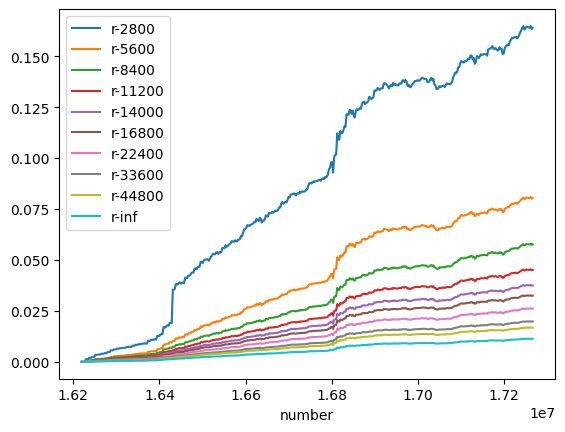

In [32]:
# fee returns in units of token1 over time
ax = df.plot(x='number', y=[f'r-{tick_width}' if tick_width > 0 else 'r-inf' for tick_width in tick_widths])
ax.get_figure().savefig('results/backtest/UniswapV3LPSimpleRunner_0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640_fee_returns_7200_16219692_17267692_2400.png')